In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from ase.io import read
import ase
import time 
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                    lm_slice, real2complex_matrix, compute_lambda_soap, xyz_to_spherical, spherical_to_xyz)
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species,mask_center_atoms_by_id

In [3]:
from skcosmo.linear_model import AtomRidge
from skcosmo.model_selection import atom_groups_by_frame, train_test_split_by_frame

In [4]:
frames = read("./train_tensor/CSD-3k+S546_shift_tensors.xyz","::20")
clean_frames = []
for f in frames:
    if f.info['STATUS'] == 'PASSING':
        clean_frames.append(f)
    else:
        print(f.info['NAME'], f.info['STATUS'])
frames = clean_frames

ORAVUZ SUSPICIOUS
SAJYEH SUSPICIOUS
DIZVOZ SUSPICIOUS
CUGLUN SUSPICIOUS


In [5]:
y = []
ty = []
s = []
atom_sigma = {'H': 0.1, 'C': 1, 'N':1, 'O':1, 'S':2}
type_idx = {'H': [], 'C': [], 'N': [], 'O': [], 'S': []}
idx = 0
groups = []
for iframe, f in enumerate(frames):
    y.append(f.arrays['cs_iso'])
    ty.append(f.arrays['cs_tensor'].reshape((-1,3,3)))
    f.wrap(eps=1e-12)
    for l in f.symbols:
        type_idx[l].append(idx)
        idx+=1
        s.append(atom_sigma[l])    
groups = atom_groups_by_frame(frames)        
cs = np.concatenate(y)
tcs = np.concatenate(ty)
sigmas = np.asarray(s)

In [6]:
f.info

{'magres_units': {'cs_tensor': 'ppm', 'cs_iso': 'ppm'},
 'STATUS': 'PASSING',
 'NAME': 'FADBOB',
 'ENERGY': -2300.05217586}

In [7]:
hypers_1 = {
    'interaction_cutoff': 6,
    'max_radial': 10,
    'max_angular': 0,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',        
    'soap_type' : "RadialSpectrum",
    'normalize' : False
}

hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',
    'normalize' : False,
    'soap_type' : "PowerSpectrum"
}

hypers_1 = get_optimal_radial_basis_hypers(hypers_1, frames, expanded_max_radial=50)
hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

In [8]:
soap1 = SphericalInvariants(**hypers_1)
soap2 = SphericalInvariants(**hypers_2)

In [9]:
feat1 = soap1.transform(frames).get_features(soap1)
feat2 = soap2.transform(frames).get_features(soap2)

In [10]:
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split

In [11]:
from skcosmo.kernel_model import RKHSTransform
from skcosmo.sample_selection import CUR, PCovCUR, FPS

In [12]:
feats = np.hstack([feat1, feat2])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [13]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,feat1.shape[1]), slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1])])

In [14]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [15]:
ar.fit(X_train, y_train, sample_sigmas=sig_train)

In [16]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12671, 12672, 12673]),
                  array([   48,    49,    50, ..., 12939, 12940, 12941])),
                 (array([   48,    49,    50, ..., 12939, 12940, 12941]),
                  array([    0,     1,     2, ..., 12671, 12672, 12673]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [17]:
gcv.cv_results_

{'mean_fit_time': array([3.00884128, 3.02311337, 3.02271986, 3.02182949, 3.0210731 ]),
 'std_fit_time': array([0.01827073, 0.01581562, 0.0114646 , 0.01067603, 0.01075959]),
 'mean_score_time': array([0.20476043, 0.20451605, 0.20471811, 0.20462191, 0.20526052]),
 'std_score_time': array([1.02639198e-04, 7.23600388e-05, 2.06708908e-04, 1.14083290e-04,
        4.34637070e-04]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-2595.76332256, -2145.61837968, -1668.99517177, -1621.08098524,
        -1622.96118848]),
 'split1_test_score': array([-2262.88967164, -2066.44850978, -2168.27007266, -2065.76989831,
        -2063.2644521 ]),
 'mean_test_score': ar

In [18]:
cs_pred = gcv.predict(feats)

In [19]:
p_test = gcv.predict(X_test)

38.91014342406648

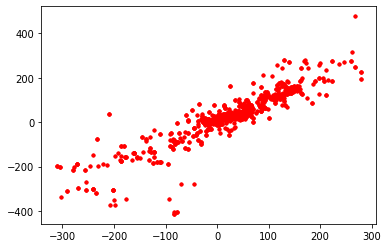

In [20]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

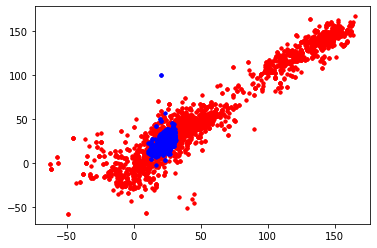

In [21]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')

In [22]:
sel = FPS(n_to_select = 1000, progress_bar=tqdm)

In [23]:
sel.fit(feats)

  0%|          | 0/999 [00:00<?, ?it/s]

FPS()

In [24]:
KBB1 = (feat1[sel.selected_idx_]@feat1[sel.selected_idx_].T)**2
KBB2 = (feat2[sel.selected_idx_]@feat2[sel.selected_idx_].T)**2

In [25]:
rkhs1 = RKHSTransform(jitter=1e-10)
rkhs1.fit(KBB1)
rkhs2 = RKHSTransform(jitter=1e-10)
rkhs2.fit(KBB2)

In [26]:
feats = np.hstack([rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [27]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,rkhs1.nB_), slice(rkhs1.nB_,rkhs1.nB_+rkhs2.nB_)])
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [28]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([   86,    87,    88, ..., 12955, 12956, 12957]),
                  array([    0,     1,     2, ..., 12507, 12508, 12509])),
                 (array([    0,     1,     2, ..., 12507, 12508, 12509]),
                  array([   86,    87,    88, ..., 12955, 12956, 12957]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 961, None),
                                                 slice(961, 1961, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [29]:
gcv.cv_results_

{'mean_fit_time': array([0.41387057, 0.4230969 , 0.42306685, 0.42185712, 0.42308915]),
 'std_fit_time': array([0.00814486, 0.00134778, 0.00310469, 0.00072861, 0.00093043]),
 'mean_score_time': array([0.05839491, 0.05821002, 0.05815911, 0.05836034, 0.05832589]),
 'std_score_time': array([3.07559967e-05, 1.00493431e-04, 1.78575516e-04, 1.08718872e-04,
        1.30772591e-04]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-8758.92649257, -5300.49645404, -2355.83650304, -2954.39770819,
        -4174.50933148]),
 'split1_test_score': array([-7187.70156678, -4392.45043573, -1908.28956996, -1696.58453034,
        -2909.34831747]),
 'mean_test_score': ar

In [30]:
cs_pred = gcv.predict(feats)

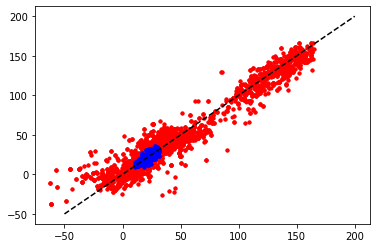

In [31]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [32]:
p_test = gcv.predict(X_test)

35.7823530309428

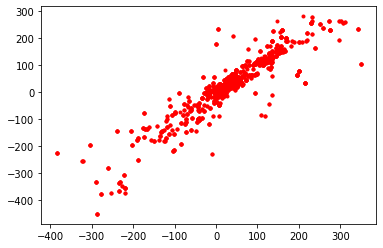

In [33]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

In [34]:
feats = np.hstack([feat1, feat2, rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
ar = AtomRidge(sigma=1, delta=[10, 2], 
               feature_groups=[slice(0,feat1.shape[1]),
                               slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1]),
                               slice(feat1.shape[1]+feat2.shape[1],feat1.shape[1]+feat2.shape[1]+rkhs1.nB_),
                               slice(feat1.shape[1]+feat2.shape[1]+rkhs1.nB_,
                                     feat1.shape[1]+feat2.shape[1]+rkhs1.nB_+rkhs2.nB_)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [35]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,1,1,1], [10,1,1,1], [1, 10, 1, 1], [1, 1, 1,10]]), cv = splits, scoring='neg_mean_squared_error')

In [36]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12557, 12558, 12559]),
                  array([   48,    49,    50, ..., 12109, 12110, 12111])),
                 (array([   48,    49,    50, ..., 12109, 12110, 12111]),
                  array([    0,     1,     2, ..., 12557, 12558, 12559]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None),
                                                 slice(6770, 7731, None),
                                                 slice(7731, 8731, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 1, 1, 1], [10, 1, 1, 1], [1, 10, 1, 1],
                                   [1, 1, 1, 10]]},
             scoring='neg_mean_squared_error')

In [37]:
gcv.cv_results_

{'mean_fit_time': array([3.261464  , 3.26072299, 3.26555324, 3.26298606]),
 'std_fit_time': array([0.00714743, 0.01153314, 0.01131701, 0.00614727]),
 'mean_score_time': array([0.24833965, 0.24717987, 0.24694252, 0.24727333]),
 'std_score_time': array([0.00077796, 0.00036871, 0.000422  , 0.00043046]),
 'param_delta': masked_array(data=[list([1, 1, 1, 1]), list([10, 1, 1, 1]),
                    list([1, 10, 1, 1]), list([1, 1, 1, 10])],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 1, 1, 1]},
  {'delta': [10, 1, 1, 1]},
  {'delta': [1, 10, 1, 1]},
  {'delta': [1, 1, 1, 10]}],
 'split0_test_score': array([-1867.94760682, -1746.48950011, -2095.16955773, -4190.41442052]),
 'split1_test_score': array([-2073.8775034 , -1964.45317961, -2312.58762926, -6489.67370036]),
 'mean_test_score': array([-1970.91255511, -1855.47133986, -2203.8785935 , -5340.04406044]),
 'std_test_score': array([ 102.96494829,  108.9818397

In [38]:
cs_pred = gcv.predict(feats)

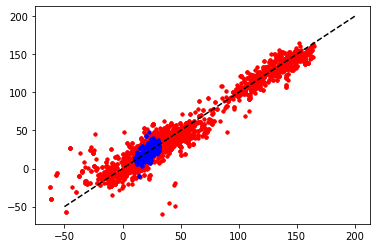

In [39]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [40]:
p_test = gcv.predict(X_test)

42.87295536540678

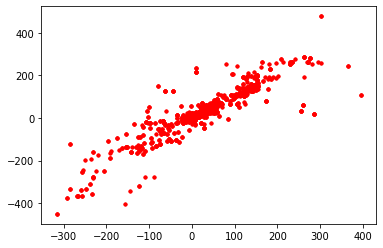

In [41]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

# Tensor stuff

In [42]:
cg = ClebschGordanReal(lmax=2)

In [43]:
tcs_coupled = cg.couple(xyz_to_spherical(tcs))

In [44]:
tcs_cart = spherical_to_xyz(cg.decouple(tcs_coupled))

In [45]:
tcs[0]

array([[  61.3422, -101.3244,   47.903 ],
       [-105.0865,  -13.6984,  -34.2244],
       [  35.4635,  -54.8832,   60.0297]])

In [46]:
print(tcs_coupled[(1,1)][0][0], tcs_coupled[(1,1)][1][0], tcs_coupled[(1,1)][2][0])

[-62.16532421] [-8.7960548   2.66020642 14.60797757] [-145.9545471   -63.00858822   29.5635449    58.94901747   53.06171712]


In [47]:
tcs_cart[0]

array([[  61.3422, -101.3244,   47.903 ],
       [-105.0865,  -13.6984,  -34.2244],
       [  35.4635,  -54.8832,   60.0297]])

In [48]:
cs[0]*np.sqrt(3)

62.163303483647006

In [49]:
tcs[0].trace()/3

35.89116666666666

In [50]:
tcs_coupled[(1,1)][2]

array([[-145.9545471 ,  -63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       [ 145.9545471 ,  -63.00858822,   29.5635449 ,  -58.94901747,
          53.06171712],
       [ 145.9545471 ,   63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       ...,
       [   3.03405378,   -3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218],
       [  -3.03405378,    3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218],
       [   3.03405378,   -3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218]])

## builds lambda-SOAP

In [51]:
hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 12,
    'max_angular': 9,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR'
}
hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

In [52]:
hypers_2

{'interaction_cutoff': 6,
 'max_radial': 12,
 'max_angular': 9,
 'gaussian_sigma_type': 'Constant',
 'gaussian_sigma_constant': 0.2,
 'cutoff_smooth_width': 0.3,
 'radial_basis': 'DVR',
 'optimization': {'RadialDimReduction': {'projection_matrices': {1: [[[0.0037809030302159022,
       0.030203827702794728,
       0.09054499333873575,
       0.18208330773740775,
       0.27956303330002563,
       0.3348886267980983,
       0.30615314908592406,
       0.20410275525806348,
       0.09369462710490684,
       0.029082115784510965,
       0.011353800918095298,
       0.018399053524393236,
       0.03253545926897267,
       0.0361449491067357,
       0.025401122698185036,
       0.023822635734220932,
       0.04522878038092791,
       0.06499646324713265,
       0.0700918005774225,
       0.08457997459140348,
       0.11023451256569142,
       0.12831780101019424,
       0.13134608414851914,
       0.13568976329565027,
       0.145682430422769,
       0.15546974686164164,
       0.1667555186

In [53]:
CG = ClebschGordanReal(lmax=hypers_2["max_angular"])

In [54]:
spex = SphericalExpansion(**hypers_2)

In [55]:
feats = spex.transform(frames).get_features(spex)
ref_feats = 1e3*spherical_expansion_reshape(feats, **hypers_2)

In [56]:
isel =type_idx['H'][::10]
nsel = len(isel)

In [57]:
nsel

643

In [58]:
lsoap = compute_lambda_soap(ref_feats[isel], CG, 2, 1)

this is a simple PCA contraction

In [68]:
lsoap.shape

(643, 5, 12, 5, 12, 17, 5)

In [70]:
lsr = np.moveaxis(lsoap,-1,1).reshape((lsoap.shape[0]*lsoap.shape[-1], -1))

In [72]:
lsr.shape

(3215, 61200)

In [60]:
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)

(0.01, 10000.0)

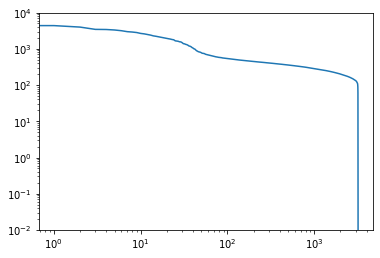

In [61]:
plt.loglog(s)
plt.ylim(1e-2,1e4)

(0.01, 10000.0)

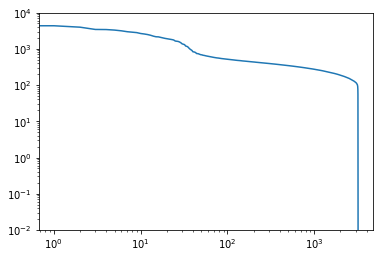

In [61]:
plt.loglog(s)
plt.ylim(1e-2,1e4)

In [62]:
vt.shape

(3215, 42500)

In [63]:
lsoap_pca = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap.shape[0], lsoap.shape[-1], -1)), 1, -1)

In [64]:
lsoap_pca.shape

(643, 1000, 5)

now do 0-1-2

no - pca

In [63]:
lsoap0 = compute_lambda_soap(ref_feats[:nsel], CG, 0, 1)
lsoap0.shape = (lsoap0.shape[0], -1, lsoap0.shape[-1])
lsoap1 = compute_lambda_soap(ref_feats[:nsel], CG, 1, -1)
lsoap1.shape = (lsoap1.shape[0], -1, lsoap1.shape[-1])
lsoap2 = compute_lambda_soap(ref_feats[:nsel], CG, 2, 1)
lsoap2.shape = (lsoap2.shape[0], -1, lsoap2.shape[-1])

pca

In [64]:
lsoap2.shape

(643, 61200, 5)

In [65]:
lsoap0 = compute_lambda_soap(ref_feats[isel], CG, 0, 1)
lsr = np.moveaxis(lsoap0,-1,1).reshape((lsoap0.shape[0]*lsoap0.shape[-1], -1))
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)
lsoap0 = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap0.shape[0], lsoap0.shape[-1], -1)), 1, -1)

In [66]:
lsoap1 = compute_lambda_soap(ref_feats[isel], CG, 1, -1)
lsr = np.moveaxis(lsoap1,-1,1).reshape((lsoap1.shape[0]*lsoap1.shape[-1], -1))
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)
lsoap1 = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap1.shape[0], lsoap1.shape[-1], -1)), 1, -1)

In [67]:
lsoap2 = compute_lambda_soap(ref_feats[isel], CG, 2, 1)
lsr = np.moveaxis(lsoap2,-1,1).reshape((lsoap2.shape[0]*lsoap2.shape[-1], -1))

u, s, vt = sp.linalg.svd(lsr, full_matrices=False)
lsoap2 = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap2.shape[0], lsoap2.shape[-1], -1)), 1, -1)

KeyboardInterrupt: 

In [69]:
from sklearn.linear_model import Ridge

In [97]:
class SASplitter:
    """ CV splitter that takes into account the presence of "L blocks"
    associated with symmetry-adapted regression. Basically, you can trick conventional
    regression schemes to work on symmetry-adapted data y^M_L(A_i) by having the (2L+1)
    angular channels "unrolled" into a flat array. Then however splitting of train/test
    or cross validation must not "cut" across the M block. This takes care of that.
    """
    def __init__(self, L, cv=2):
        self.L = L
        self.cv = cv
        self.n_splits = cv

    def split(self, X, y, groups=None):

        ntrain = X.shape[0]
        if ntrain % (2*self.L+1) != 0:
            raise ValueError("Size of training data is inconsistent with the L value")
        ntrain = ntrain // (2*self.L+1)
        nbatch = (2*self.L+1)*(ntrain//self.n_splits)
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        for n in range(self.n_splits):
            itest = idx[n*nbatch:(n+1)*nbatch]
            itrain = np.concatenate([idx[:n*nbatch], idx[(n+1)*nbatch:]])
            yield itrain, itest

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits
    
class SARidge(Ridge):
    """ Symmetry-adapted ridge regression class """

    def __init__(self, L, alpha=1, alphas=None, cv=2, solver='auto',
                 fit_intercept=False, scoring='neg_root_mean_squared_error'):
        self.L = L
        # L>0 components have zero mean by symmetry
        if L>0:
            fit_intercept = False
        self.cv = SASplitter(L, cv)
        self.alphas = alphas
        self.cv_stats = None
        self.scoring = scoring
        self.solver = solver
        super(SARidge, self).__init__(alpha=alpha, fit_intercept=fit_intercept, solver=solver)

    def fit(self, Xm, Ym, precomputed=False, X0=None):
        # this expects properties in the form [i, m] and features in the form [i, q, m]
        # in order to train a SA-GPR model the m indices have to be moved and merged with the i
        
        
        
        if precomputed is True:
            Xm_flat = Xm
        else:
            Xm_flat = np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1])) 
        
        Ym_flat = Ym.flatten()
        
        if self.alphas is not None:
            # determines alpha by grid search
            rcv = Ridge(fit_intercept=self.fit_intercept)
            gscv = GridSearchCV(rcv, dict(alpha=self.alphas), cv=self.cv, scoring=self.scoring)
            gscv.fit(Xm_flat, Ym_flat)
            self.cv_stats = gscv.cv_results_
            self.alpha = gscv.best_params_["alpha"]

        super(SARidge, self).fit(Xm_flat, Ym_flat)
    
    def predict(self, Xm, precomputed=False,X0=None):
        if precomputed is True:
            Y = super(SARidge, self).predict(Xm)
        else:
            Y = super(SARidge, self).predict(np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1])))
        return Y.reshape((-1, 2*self.L+1))

In [71]:
from sklearn.kernel_approximation import Nystroem
from sklearn.base import TransformerMixin, BaseEstimator

In [72]:
np.moveaxis(lsoap2[::2], 2, 1).reshape((-1, lsoap2[::2].shape[1])).shape

(1610, 1000)

In [73]:
tgt0 = tcs_coupled[(1,1)][0][isel]
tgt1 = tcs_coupled[(1,1)][1][isel]
tgt2 = tcs_coupled[(1,1)][2][isel]

In [168]:
reg = 1e3
sar0 = SARidge(L=0, alpha=reg)
sar1 = SARidge(L=1, alpha=reg)
sar2 = SARidge(L=2, alpha=reg)

In [169]:
sar0.fit(lsoap0[::2], tgt0[::2])
sar1.fit(lsoap1[::2], tgt1[::2])
sar2.fit(lsoap2[::2], tgt2[::2])

In [76]:
lsoap2[::2].shape

(322, 1000, 5)

In [77]:
def f2v(vec):
    t = ()
    for s in vec.shape:
        t += (s//5,5)
    return vec.reshape(t)

def v2f(vec):
    t = ()
    for s in vec.shape[:-1:2]:        
        t += tuple([s*5])
    if len(vec.shape)%2==1:
        t += tuple([-1])
    return vec.reshape(t)

In [78]:
lX_test  = np.moveaxis(lsoap2,2,1)
lX_train = np.moveaxis(lsoap2[::2],2,1) 

In [79]:
lX_test.shape

(643, 5, 1000)

In [80]:
ntot = len(lX_train)
itrain = np.arange(ntot)
np.random.seed(42)
np.random.shuffle(itrain)
isparse = np.arange(ntot)[::2]
np.random.shuffle(isparse)

In [81]:
ntot

322

In [82]:
lsoap2[::2].shape

(322, 1000, 5)

In [153]:
from scipy.linalg import svd
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import pairwise_kernels, KERNEL_PARAMS
import warnings

class SANystroem(Nystroem,TransformerMixin,BaseEstimator):
    #maybe add L handling later   
    def __init__(
        self,
        L,
        kernel="linear",
        *,
        gamma=None,
        coef0=None,
        degree=None,
        kernel_params=None,
        n_components=100,
        random_state=None,
        n_jobs=None,
        non_linear_kernel="rbf",
        L0_features=None
    ):
        
        if kernel != "linear":
            raise ValueError("Kernel must be linear")
        self.kernel = kernel
        self.L = L
        self.gamma = gamma
        self.coef0 = coef0
        self.degree = degree
        self.kernel_params = kernel_params
        self.n_components = n_components
        self.random_state = random_state
        self.n_jobs = n_jobs
        
        
        
    def fit(self, X, y=None, base_indices=None, autoselect=False):
        """
        Additions: flatting array
                   passing indices
        Fit estimator to data.
        Samples a subset of training points, computes kernel
        on these and computes normalization matrix.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs), \
                default=None
            Target values (None for unsupervised transformations).
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        
        rnd = check_random_state(self.random_state)
        n_samples = X.shape[0]

        # get basis vectors
        if self.n_components > n_samples:
            # XXX should we just bail?
            n_components = n_samples
            warnings.warn(
                "n_components > n_samples. This is not possible.\n"
                "n_components was set to n_samples, which results"
                " in inefficient evaluation of the full kernel."
            )

        else:
            n_components = self.n_components
        n_components = min(n_samples, n_components)
        inds = rnd.permutation(n_samples)
        
        if base_indices is not None:
            basis_inds = base_indices
        else:
            basis_inds = inds[:n_components]
        
        
        #add autoselect in here!
        basis = X[basis_inds]
        
        #do the reshape here!!
        basis = np.moveaxis(basis, 2, 1).reshape((-1, basis.shape[1]))
        basis = self._validate_data(basis, accept_sparse="csr")

        basis_kernel = pairwise_kernels(
            basis,
            metric=self.kernel,
            filter_params=True,
            n_jobs=self.n_jobs,
            **self._get_kernel_params(),
        )

        # sqrt of kernel matrix on basis vectors
        U, S, V = svd(basis_kernel)
        S = np.maximum(S, 1e-12)
        self.normalization_ = np.dot(U / np.sqrt(S), V)
        self.components_ = basis
        self.component_indices_ = basis_inds
        return self 
        
    def transform(self,Xm):
        #[i, q, m] -> [i,m,q] -> [i,m*q]
        Xm_flat = np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1]))
        KMN = super().transform(Xm_flat)
        # TODO: Check if this is correct and write test
        return KMN
        
    #fittransform will call child-class fit and transform ?

In [206]:
feature_map_nystroem = SANystroem(L=2,kernel='linear',
                                n_components=150)
feature_map_nystroem.fit(lsoap2[::2])
this2 = feature_map_nystroem.transform(lsoap2[::2])
this2_ = feature_map_nystroem.transform(lsoap2)
feature_map_nystroem = SANystroem(L=1,kernel='linear',
                                n_components=100)
this1 = feature_map_nystroem.fit_transform(lsoap1[::2])
this1_ = feature_map_nystroem.transform(lsoap1)
feature_map_nystroem = SANystroem(L=0,kernel='linear',
                                n_components=100)
feature_map_nystroem.fit(lsoap0[::2])
this0 = feature_map_nystroem.transform(lsoap0[::2])
this0_ = feature_map_nystroem.transform(lsoap0)

In [158]:
this1.shape

(966, 300)

In [159]:
this0.shape

(322, 100)

In [160]:
this.shape

(966, 500)

In [109]:
tostacks = [this for _ in range(5)]

In [132]:
test = np.stack(tostacks,axis=1)

In [114]:
np.tile(this,(5,1)).shape

(8050, 1000)

In [217]:
sar0 = SARidge(L=0, alphas=np.logspace(-5,5,25))
sar1 = SARidge(L=1, alpha=reg)
sar2 = SARidge(L=2, alpha=reg)

In [218]:
sar1.fit(this1, tgt1[::2],precomputed=True)
sar2.fit(this2, tgt2[::2],precomputed=True)
sar0.fit(this0, tgt0[::2],precomputed=True)

In [221]:
sar2.alpha

1000.0

In [231]:
this2_.shape

(3215, 750)

In [222]:
pred2 = sar2.predict(this2_,precomputed=True)
pred1 = sar1.predict(this1_,precomputed=True)
pred0 = sar0.predict(this0_,precomputed=True)

In [223]:
pred2.shape

(643, 5)

In [224]:
tgt2.shape

(643, 5)

In [225]:
feature_map_nystroem.get_params()

AttributeError: 'SANystroem' object has no attribute 'L0_features'

In [108]:
type(data_transformed)

NoneType

In [136]:
lX_train.shape

(322, 5, 1000)

In [82]:
lKNM = f2v(v2f(lX_train[itrain]) @ v2f(lX_train[isparse]).T)
lKMM = f2v(v2f(lX_train[isparse]) @ v2f(lX_train[isparse]).T)
lKM = f2v(v2f(lX_test) @ v2f(lX_train[isparse]).T)

In [83]:
wlsparse = f2v( np.linalg.lstsq(v2f(lKNM).T@v2f(lKNM) + v2f(lKMM), 
                           v2f(lKNM).T@v2f(tgt2[::2][itrain]), rcond=None)[0] )

In [84]:
ylpred_sparse = f2v(v2f(lKM) @ v2f(wlsparse) )

In [85]:
ylpred_sparse.shape

(643, 5)

In [86]:
np.mean(np.abs(ylpred_sparse[1::2]))

3.3859776345923875

In [163]:
plt.plot(ylpred_sparse[1::2].flatten(), tgt2[1::2].flatten(), 'b.')
plt.plot(ylpred_sparse[::2].flatten(), tgt2[::2].flatten(), 'r.')
print(np.mean(np.abs(ylpred_sparse[1::2]- tgt2[1::2])))

NameError: name 'ylpred_sparse' is not defined

In [170]:
pred0 = sar0.predict(lsoap0)
pred1 = sar1.predict(lsoap1)
pred2 = sar2.predict(lsoap2)

In [89]:
pred2.shape

(643, 5)

2.6633258617944255


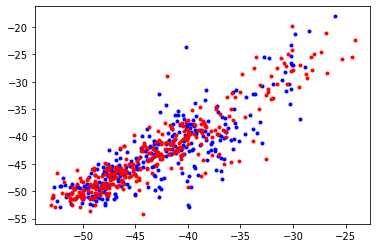

In [226]:
plt.plot(pred0[1::2], tgt0[1::2], 'b.')
plt.plot(pred0[::2], tgt0[::2], 'r.')
print(np.mean(np.abs(pred0[1::2]-tgt0[1::2])))

2.6224371324940674


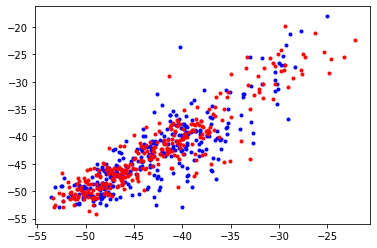

In [210]:
plt.plot(pred0[1::2], tgt0[1::2], 'b.')
plt.plot(pred0[::2], tgt0[::2], 'r.')
print(np.mean(np.abs(pred0[1::2]-tgt0[1::2])))

2.1536229755607676


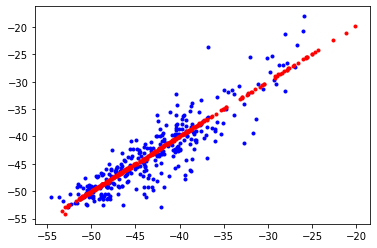

In [172]:
plt.plot(pred0[1::2], tgt0[1::2], 'b.')
plt.plot(pred0[::2], tgt0[::2], 'r.')
print(np.mean(np.abs(pred0[1::2]-tgt0[1::2])))

0.7592021118148901


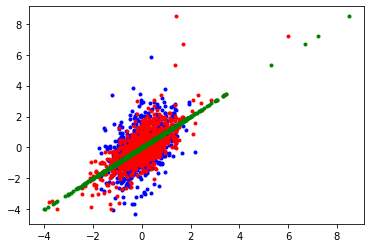

In [211]:
plt.plot(pred1[1::2].flatten(), tgt1[1::2].flatten(), 'b.')
plt.plot(pred1[::2].flatten(), tgt1[::2].flatten(), 'r.')
plt.plot(tgt1[::2].flatten(), tgt1[::2].flatten(), 'g.')
print(np.mean(np.abs(pred1[1::2]-tgt1[1::2])))

0.7592021118148901


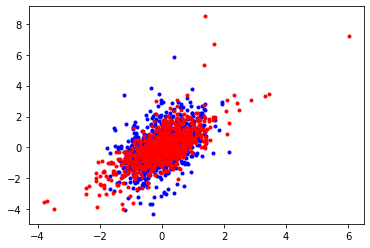

In [212]:
plt.plot(pred1[1::2].flatten(), tgt1[1::2].flatten(), 'b.')
plt.plot(pred1[::2].flatten(), tgt1[::2].flatten(), 'r.')
print(np.mean(np.abs(pred1[1::2]-tgt1[1::2])))

0.7592021118148901


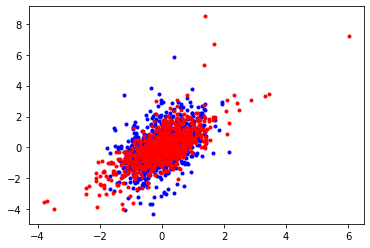

In [213]:
plt.plot(pred1[1::2].flatten(), tgt1[1::2].flatten(), 'b.')
plt.plot(pred1[::2].flatten(), tgt1[::2].flatten(), 'r.')
print(np.mean(np.abs(pred1[1::2]-tgt1[1::2])))

1.330218755212525


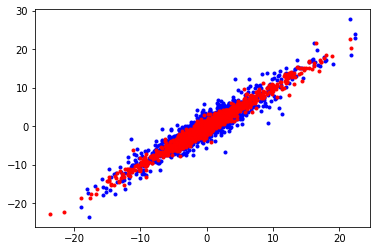

In [214]:
plt.plot(pred2[1::2].flatten(), tgt2[1::2].flatten(), 'b.')
plt.plot(pred2[::2].flatten(), tgt2[::2].flatten(), 'r.')
print(np.mean(np.abs(pred2[1::2]- tgt2[1::2])))

In [178]:
pred2[0::2].shape

(322, 5)

1.2364147738450226


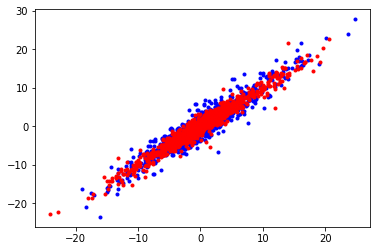

In [156]:
plt.plot(pred2[1::2].flatten(), tgt2[1::2].flatten(), 'b.')
plt.plot(pred2[::2].flatten(), tgt2[::2].flatten(), 'r.')
print(np.mean(np.abs(pred2[1::2]- tgt2[1::2])))

In [228]:
from skcosmo.sample_selection import CUR

In [230]:
selector = CUR(
                    progress_bar=True,
                    score_threshold=1E-12,
                    full=False,

                    # int, number of eigenvectors to use in computing pi
                    k = 1,

                    # boolean, whether to orthogonalize after each selection, defaults to true
                    iterative = True,

                    # float, threshold below which scores will be considered 0, defaults to 1E-12
                    tolerance=1E-12,
                    )
selector.fit(lsoap0[::2].reshape(lsoap0[::2].))

ValueError: Found array with dim 3. Estimator expected <= 2.